<a href="https://colab.research.google.com/github/ajoshiusc/lesion-detector/blob/master/lesion-detector/src/sergul/ReNA_ISLES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initialization 

In [1]:
#import packages
!pip install utilis nilearn nibabel


    100% |████████████████████████████████| 2.3MB 12.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/36/ad/20/c28a4ec7f29505b910418f843a7d3a1ce1ef52787f7d7a8ca4
Successfully built utilis


In [0]:
import matplotlib as plt
%matplotlib inline

In [2]:
# access personal google drive to import ISLES dataset
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


# rena.py


In [3]:
%%writefile rena.py

"""Recursive nearest agglomeration (ReNA):
    fastclustering for approximation of structured signals
Author:
    Andres Hoyos idrobo, Gael Varoquaux, Jonas Kahn and  Bertrand Thirion
"""
import numpy as np
from sklearn.utils.validation import check_is_fitted
from sklearn.externals.joblib import Parallel, delayed, Memory
from sklearn.externals import six
from scipy.sparse import csgraph, coo_matrix, dia_matrix
from sklearn.base import BaseEstimator
from sklearn.utils import check_array


def _compute_weights(masker, data_matrix):
    """Measuring the Euclidean distance: computer the weights in the direction
    of each axis
    Note: Here we are assuming a square lattice (no diagonal connections)
    """
    # data_graph shape
    dims = len(masker.mask_img_.shape)
    data_graph = masker.inverse_transform(data_matrix).get_data()
    weights = []

    for axis in range(dims):
        weights.append(
            np.sum(np.diff(data_graph, axis=axis) ** 2, axis=-1).ravel())

    return np.hstack(weights)


def _compute_edges(data_graph, is_mask=False):
    """
    """
    dims = len(data_graph.shape)
    edges = []
    for axis in range(dims):
        vertices_axis = np.swapaxes(data_graph, 0, axis)

        if is_mask:
            edges.append(np.logical_and(
                vertices_axis[:-1].swapaxes(axis, 0).ravel(),
                vertices_axis[1:].swapaxes(axis, 0).ravel()))
        else:
            edges.append(np.vstack(
                [vertices_axis[:-1].swapaxes(axis, 0).ravel(),
                 vertices_axis[1:].swapaxes(axis, 0).ravel()]))
    edges = np.hstack(edges)
    return edges


def _create_ordered_edges(masker, data_matrix):
    """
    """
    mask = masker.mask_img_.get_data()
    shape = mask.shape
    n_features = np.prod(shape)

    vertices = np.arange(n_features).reshape(shape)
    weights = _compute_weights(masker, data_matrix)
    edges = _compute_edges(vertices, is_mask=False)
    edges_mask = _compute_edges(mask, is_mask=True)

    # Apply the mask
    weights = weights[edges_mask]
    edges = edges[:, edges_mask]

    # Reorder the indices of the graph
    max_index = edges.max()
    order = np.searchsorted(np.unique(edges.ravel()), np.arange(max_index + 1))
    edges = order[edges]

    return edges, weights, edges_mask


def weighted_connectivity_graph(masker, data_matrix):
    """ Creating weighted graph
    data and topology, encoded by a connectivity matrix
    """
    n_features = masker.mask_img_.get_data().sum()

    edges, weight, edges_mask = _create_ordered_edges(masker, data_matrix)
    connectivity = coo_matrix(
        (weight, edges), (n_features, n_features)).tocsr()

    # Making it symmetrical
    connectivity = (connectivity + connectivity.T) / 2

    return connectivity


def _nn_connectivity(connectivity, thr):
    """ Fast implementation of nearest neighbor connectivity
    connectivity: weighted connectivity matrix
    """
    n_features = connectivity.shape[0]

    connectivity_ = coo_matrix(
        (1. / connectivity.data, connectivity.nonzero()),
        (n_features, n_features)).tocsr()

    inv_max = dia_matrix((1. / connectivity_.max(axis=0).toarray()[0], 0),
                         shape=(n_features, n_features))

    connectivity_ = inv_max * connectivity_

    # Dealing with eccentricities
    edge_mask = connectivity_.data > 1 - thr

    j_idx = connectivity_.nonzero()[1][edge_mask]
    i_idx = connectivity_.nonzero()[0][edge_mask]

    weight = np.ones_like(j_idx)
    edges = np.array((i_idx, j_idx))

    nn_connectivity = coo_matrix((weight, edges), (n_features, n_features))

    return nn_connectivity


def reduce_data_and_connectivity(labels, n_labels, connectivity, data_matrix,
                                 thr):
    """
    """
    n_features = len(labels)

    incidence = coo_matrix(
        (np.ones(n_features), (labels, np.arange(n_features))),
        shape=(n_labels, n_features), dtype=np.float32).tocsc()

    inv_sum_col = dia_matrix(
        (np.array(1. / incidence.sum(axis=1)).squeeze(), 0),
        shape=(n_labels, n_labels))

    incidence = inv_sum_col * incidence

    # reduced data
    reduced_data_matrix = (incidence * data_matrix.T).T
    reduced_connectivity = (incidence * connectivity) * incidence.T

    reduced_connectivity = reduced_connectivity - dia_matrix(
        (reduced_connectivity.diagonal(), 0), shape=(reduced_connectivity.shape))

    i_idx, j_idx = reduced_connectivity.nonzero()

    data_matrix_ = np.maximum(thr, np.sum(
        (reduced_data_matrix[:, i_idx] - reduced_data_matrix[:, j_idx]) ** 2, 0))
    reduced_connectivity.data = data_matrix_

    return reduced_connectivity, reduced_data_matrix


def nearest_neighbor_grouping(connectivity, data_matrix, n_clusters, thr):
    """ Cluster according to nn and reduce the data and connectivity
    """
    # Nearest neighbor conenctivity
    nn_connectivity = _nn_connectivity(connectivity, thr)

    n_features = connectivity.shape[0]

    n_labels = n_features - (nn_connectivity + nn_connectivity.T).nnz / 2

    if n_labels < n_clusters:
        # cut some links to achieve the desired number of clusters
        alpha = n_features - n_clusters

        nn_connectivity = nn_connectivity + nn_connectivity.T

        edges_ = np.array(nn_connectivity.nonzero())

        plop = edges_[0] - edges_[1]

        select = np.argsort(plop)[:alpha]

        nn_connectivity = coo_matrix(
            (np.ones(2 * alpha),
             np.hstack((edges_[:, select], edges_[::-1, select]))),
            (n_features, n_features))

    # Clustering step: getting the connected components of the nn matrix
    n_labels, labels = csgraph.connected_components(nn_connectivity)

    # Reduction step: reduction by averaging
    reduced_connectivity, reduced_data_matrix = reduce_data_and_connectivity(
        labels, n_labels, connectivity, data_matrix, thr)

    return reduced_connectivity, reduced_data_matrix, labels


def recursive_nearest_agglomeration(masker, data_matrix, n_clusters, n_iter,
                                    thr):
    """
    """
    # Weighted connectivity matrix
    connectivity = weighted_connectivity_graph(masker, data_matrix)

    # Initialization
    labels = np.arange(connectivity.shape[0])
    n_labels = connectivity.shape[0]

    for i in range(n_iter):
        connectivity, data_matrix, reduced_labels = nearest_neighbor_grouping(
            connectivity, data_matrix, n_clusters, thr)

        labels = reduced_labels[labels]
        n_labels = connectivity.shape[0]

        if n_labels <= n_clusters:
            break

    return n_labels, labels



class ReNA(BaseEstimator):
    """
    ReNA is useful.
    Parameters
    ----------
    masker: dd
    n_cluster: int, optional (default 2)
        Number of clusters.
    connectivity
    scaling: bool, optional (default False)
    memory: instance of joblib.Memory or string
        Used to cache the masking process.
        By default, no caching is done. If a string is given, it is the
        path to the caching directory.
    n_iter: int, optional (default 10)
        Number of iterations of the recursive nearest agglomeration
    n_jobs: int, optional (default 1)
        Number of jobs in solving the sub-problems.
    thr: float in the opened interval (0., 1.), optional (default 1e-7)
        Threshold used to deal with eccentricities.
    Attributes
    ----------
    `labels_`: numpy array
    `n_clusters_`: int
        Number of clusters
    `sizes_`: numpy array
        It contains the size of each cluster
    """
    def __init__(self, n_clusters=2, connectivity=None, masker=None, memory=None,
                 scaling=False, n_iter=10, thr=1e-7, n_jobs=1):
        self.n_clusters = n_clusters
        self.connectivity = connectivity
        self.memory = memory
        self.scaling = scaling
        self.n_iter = n_iter
        self.n_jobs = n_jobs
        self.masker = masker
        self.thr = thr

    def fit(self, X):
        """Compute clustering of the data
        Parameters
        ----------
        X : 2D array
        """

        X = check_array(X, ensure_min_features=2)

        memory = self.memory
        if isinstance(memory, six.string_types):
            memory = Memory(cachedir=memory, verbose=0)

        if self.n_clusters <= 0:
            raise ValueError("n_clusters should be an integer greater than 0."
                             " %s was provided." % str(self.n_clusters))

        n_labels, labels = recursive_nearest_agglomeration(
            self.masker, X, self.n_clusters, n_iter=self.n_iter, thr=self.thr)

        sizes = np.bincount(labels)
        sizes = sizes[sizes > 0]

        self.labels_ = labels
        self.n_clusters_ = np.unique(self.labels_).shape[0]
        self.sizes_ = sizes
        self.n_features = X.shape[1]
        
        return self


    def transform(self, X):
        """Apply clustering, reduce the dimensionality of the data
        Parameters
        ----------
        X: 2D array
        """
        N = X.shape[0]
        check_is_fitted(self, 'labels_')
        #unique_labels = np.unique(self.labels_)

#         nX = []
#         for l in unique_labels:
#             nX.append(np.mean(X[:, self.labels_ == l], axis=1))
#         Xred =  np.array(nX).T
        Xred = np.array([np.bincount(self.labels_, X[i,:])/self.sizes_ for i in range(N)])

        if self.scaling:
            Xred = Xred * np.sqrt(self.sizes_)

        return Xred
    
#     def generate_phi(self)
#         phi_T = cluster.transform( np.eye(self.n_features))
#         phi = phi_T.T # do sparse
#         self.phi = phi
#         return self

    def fit_transform(self, X):
        """Fit to data, then perform the clustering (transformation)
        """
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, Xred):
        """
        """
        check_is_fitted(self, 'labels_')

        _, inverse = np.unique(self.labels_, return_inverse=True)

        if self.scaling:
            Xred = Xred / np.sqrt(self.sizes_)
        return Xred[..., inverse]

Writing rena.py


# Run ReNA on the Dataset ISLES2015

In [4]:
# setup masker 
import nibabel as nb
from nilearn.input_data import NiftiMasker
import nilearn

# using here StandardMNI for stroke dataset
mask_img = nb.load('/content/drive/My Drive/be engineer/CV & personal stuff/scolarship/master Admission/school work/SIT_GDrive/Spring 2019 Term/MIR_project/public_data/ATLAS_R1.1/standard_mni152_bfc.nii.gz')
nifti_masker = NiftiMasker(smoothing_fwhm=False,
                           standardize=False, mask_strategy='background')

nifti_masker.fit('/content/drive/My Drive/be engineer/CV & personal stuff/scolarship/master Admission/school work/SIT_GDrive/Spring 2019 Term/MIR_project/public_data/ATLAS_R1.1/standard_mni152_bfc.nii.gz')


/usr/local/lib/python3.6/dist-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


NiftiMasker(detrend=False, dtype=None, high_pass=None, low_pass=None,
      mask_args=None, mask_img=None, mask_strategy='background',
      memory=Memory(location=None), memory_level=1, sample_mask=None,
      sessions=None, smoothing_fwhm=False, standardize=False, t_r=None,
      target_affine=None, target_shape=None, verbose=0)

In [5]:
# Concatenate data and run it on ReNA
# number of cluster is 400 here
import nilearn 
from nilearn import image
from nilearn.input_data import NiftiMasker
import nibabel as nb
import os
import numpy as np
import rena
import matplotlib.pyplot as plt
import glob
import pandas as pd

# Befor run edit the dir_name to the path of your subject; include / at the end
dir_name = "/content/drive/My Drive/ISLES2015/"

f_len = len(dir_name.split('/'))
f_len = f_len-2

'''USE the masker in the above different masker '''


def subject_checker(study_folder):
    
    subject_list = glob.glob(study_folder + 'Training/*/')
    target_subject = []

    for subject in subject_list:
      
      t1file = os.path.join(subject,'T1mni.nii.gz')
      t2file = os.path.join(subject,'T2mni.nii.gz')
      fl = os.path.join(subject,'FLAIRmni.nii.gz')

      if not (os.path.isfile(t1file) and os.path.isfile(t2file) 
              and os.path.isfile(fl)):
          print("one file missing at ", subject.split('/')[f_len+1]," (T1,T2 or FLAIR), go to the next subject\n")
          continue 
      else:
        target_subject.append(subject)
    
    return target_subject
      
def get_single_subject(file_name):
  
    t1file = os.path.join(file_name, 'T1mni.nii.gz')
    t2file = os.path.join(file_name, 'T2mni.nii.gz')
    fl = os.path.join(file_name, 'FLAIRmni.nii.gz')

    t1 = nifti_masker.transform(image.load_img(t1file))
    t2 = nifti_masker.transform(image.load_img(t2file))
    flair = nifti_masker.transform(image.load_img(fl))

    p = np.percentile(np.ravel(t1), 95)  # normalize to 95 percentile
    t1 = np.float32(t1) / p

    p = np.percentile(np.ravel(t2), 95)  # normalize to 95 percentile
    t2 = np.float32(t2) / p

    p = np.percentile(np.ravel(flair), 95)  # normalize to 95 percentile
    flair = np.float32(flair) / p

    imgs = np.concatenate((t1, t2, flair))

    return imgs

all_imgs = None

# checker include only the subject with T1,T2 and FLAIR MRI data
#subject_list = subject_checker_T1(dir_name)
subject_list = subject_checker(dir_name)
#print(subject_list) # just to chekc we have the right subject 

  
limiter = 0
for subject_name in subject_list:
    if limiter == 10000:
      break
    
    file_name = subject_name
    #file_name = os.path.join(dir_name, subject_name)
    imgs = get_single_subject(file_name)
    
    if all_imgs is None:
        all_imgs = imgs
    else:
        if np.any(all_imgs)== False:
          continue
        all_imgs = np.concatenate((all_imgs, imgs))
    limiter += 1
      
print('all images concatenate shape is ',all_imgs.shape,'\n')

n_voxels = all_imgs.shape[1]
n_samples = all_imgs.shape[0]
n_clusters = 400 #int((20)*(n_voxels)/100) # for 12 cluster use 0.0046875%
                                           # for 425 clusters use 0.157421875
cluster = rena.ReNA(scaling=True,
               n_clusters=n_clusters,
               masker=nifti_masker)

print(' no. of voxels: ',n_voxels,'\n',
      'no. of samples: ',n_samples,'\n',
      'no. of clusters: ',n_clusters,'\n\n')



labels_plot = []
for labels_p in subject_list:
    c_list = glob.glob(labels_p + '*')
    for c in c_list:
      if c.split('/')[f_len+3] == 'T1mni.nii.gz':
        labels_plot.append(c.split('/')[f_len+2] + '-' + c.split('/')[f_len+3][0:2])
    for c in c_list:
      if c.split('/')[f_len+3] == 'T2mni.nii.gz':
        labels_plot.append(c.split('/')[f_len+2] + '-' + c.split('/')[f_len+3][0:2])
    for c in c_list:
      if c.split('/')[f_len+3] == 'FLAIRmni.nii.gz':
        labels_plot.append(c.split('/')[f_len+2] + '-' + c.split('/')[f_len+3][0:2])


cluster.fit(all_imgs)

reduced_images = cluster.transform(all_imgs)
reconstructed_images = cluster.inverse_transform(reduced_images)

mse = np.mean(abs(all_imgs - reconstructed_images)**2, axis=1)

a_relative_chg = np.array(abs(all_imgs - reconstructed_images)/abs(all_imgs))
a_relative_chg2 = np.array(abs(all_imgs - reconstructed_images)/abs(np.maximum(all_imgs, reconstructed_images)))
a_relative_chg3 = np.array(abs(all_imgs - reconstructed_images)/(abs(all_imgs + reconstructed_images))/2)

se = np.array(abs(all_imgs - reconstructed_images)**2)
se2 = np.array(abs(all_imgs - reconstructed_images)**2/abs(all_imgs))
se3 = np.array(abs(all_imgs - reconstructed_images)**6)

/usr/local/lib/python3.6/dist-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/usr/local/lib/python3.6/dist-packages/nilearn/image/image.py:192: UserWarning: The parameter 'fwhm' for smoothing is specified as False. Converting to None (no smoothing option)
  .format(fwhm))
/usr/local/lib/python3.6/dist-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/usr/local/lib/python3.6/dist-packages/nilearn/image/image.py:192: UserWarning: The parameter 'fwhm' for smoothing is specified as False. Converting to None (no smoothing optio

all images concatenate shape is  (84, 1727327) 

 no. of voxels:  1727327 
 no. of samples:  84 
 no. of clusters:  400 




/usr/local/lib/python3.6/dist-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: RuntimeWarning: divide by zero encountered in true_divide


# Plot reults for specific subject

In [6]:
# sorted tabel for MSE with label name 
df1 = pd.Series(labels_plot)
df2 = pd.Series(mse)
df = pd.DataFrame(df1,columns=['Subject'])
df['MSE'] = df2
df = df.sort_values(by='MSE',ascending=False)
df

,Subject,MSE
47,27-FL,0.051558
17,21-FL,0.050649
62,16-FL,0.049251
50,24-FL,0.047222
14,18-FL,0.045184
41,23-FL,0.041440
74,22-FL,0.040262
68,13-FL,0.039086
44,25-FL,0.038450
59,12-FL,0.038044


In [0]:
# choose subject and setup index
# use table above to edit name of idex "27-FL" and indx2 27
indx_pt = labels_plot.index('2-FL')
idx2 = 2
ccoords = (0,0,0)

In [11]:
#interactive plot
import nilearn.image as ni
from nilearn import plotting



sublesion = '/content/drive/My Drive/ISLES2015/Training/'+str(idx2)+'/SEGMENTATIONmni.nii.gz'
islesion = nb.load(sublesion)

# add bg_img for overlay of segmentation as commented below
plotting.view_img(nifti_masker.inverse_transform(a_relative_chg2[indx_pt]),title="interactive plot")

# plotting.view_img(nifti_masker.inverse_transform(a_relative_chg3[indx_pt]),bg_img=islesion, title="epi", cut_coords=ccoords,black_bg='True',colorbar=True)


/usr/local/lib/python3.6/dist-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/usr/local/lib/python3.6/dist-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


/usr/local/lib/python3.6/dist-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


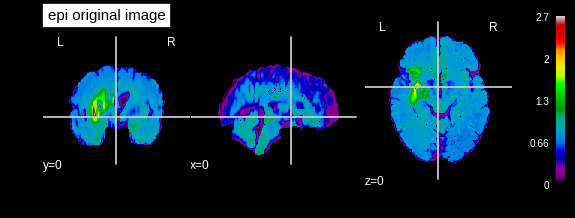

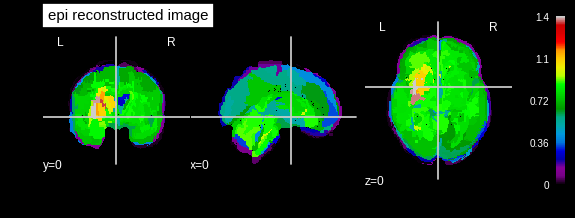

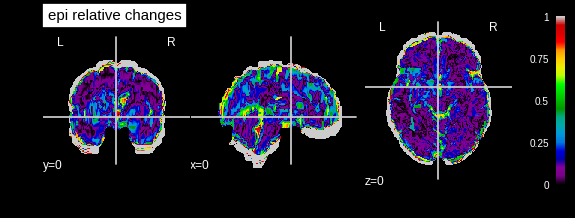

In [14]:
#static plot for original reconstracted relative changes
plotting.plot_epi(nifti_masker.inverse_transform(all_imgs[indx_pt]), title="epi original image", cut_coords=ccoords,black_bg='True',colorbar=True)
plotting.plot_epi(nifti_masker.inverse_transform(reconstructed_images[indx_pt]), title="epi reconstructed image", cut_coords=ccoords,black_bg='True',colorbar=True)
plotting.plot_epi(nifti_masker.inverse_transform(a_relative_chg2[indx_pt]), title="epi relative changes", cut_coords=ccoords,black_bg='True',colorbar=True)
